In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 596, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 596 (delta 128), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (596/596), 195.77 KiB | 1.05 MiB/s, done.
Resolving deltas: 100% (302/302), done.


In [2]:
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

PLEASE READ FOR 21.06
********************************************************************************************************
Another release, another script change.  We had to revise the script, which now:
1. Does a more comprehensive install
2. Includes BlazingSQL
3. is far easier for everyone to understand and maintain

The script will require you to add these 5 cells to your notebook.  We have also created a new startup template: 
https://colab.research.google.com/drive/1TAAi_szMfWqRfHVfjGSqnGVLr_ztzUM9?usp=sharing

CHANGES T
CELL 1:
    # This get the RAPIDS-Colab install files and test check your GPU.  Run cells 1 and 2 only.
    # Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
    !python rapidsai-csp-utils/colab/env-check.py

CELL 2:
    # This will update the Colab environment and restart the kernel.
    !bash rapidsai-csp-

In [3]:
# SETUP & IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense

import cudf
from cuml.linear_model import LogisticRegression as cuLogisticRegression

from google.colab import files

In [4]:
# DATA LOADING & CLEANING

df = pd.read_csv('flood_database.csv')
df = df.dropna()
df = df.drop(columns=["FloodLabel"])

In [5]:
# Binarize the target
threshold = 0.55
df['FloodClass'] = (df["FloodProbability"] > threshold).astype(int)

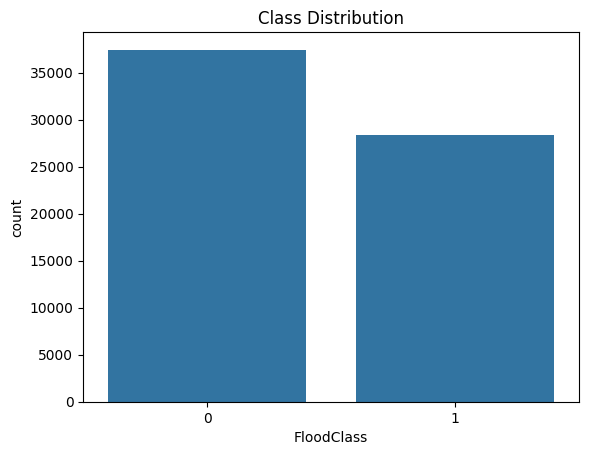

In [6]:
# Class Balance
sns.countplot(x=df['FloodClass'])
plt.title("Class Distribution")
plt.show()

X = df.drop(columns=["FloodProbability", "FloodClass"])
y = df['FloodClass']

In [7]:
# SCALING & SPLITTING


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42)

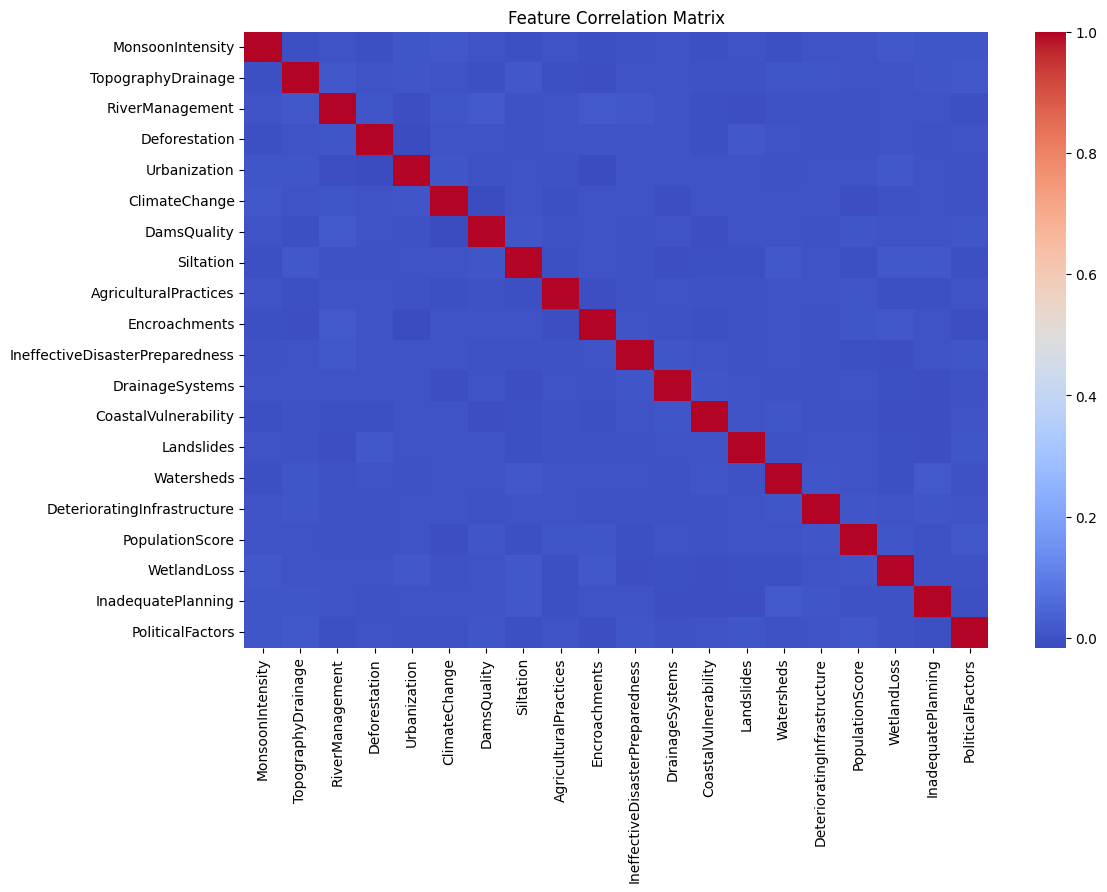

In [8]:
# Feature Correlation Matrix

corr_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [9]:
# GPU MODEL


model_gpu = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_gpu.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

with tf.device('/GPU:0'):
    start = time.time()
    history_gpu = model_gpu.fit(
        X_train, y_train, epochs=10, batch_size=256, validation_split=0.2, verbose=0)
    gpu_time = time.time() - start


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Evaluate
gpu_loss, gpu_acc = model_gpu.evaluate(X_test, y_test)
print(f"⚡ GPU Accuracy: {gpu_acc:.4f} | Time: {gpu_time:.2f} sec")


617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8513 - loss: 0.3285
⚡ GPU Accuracy: 0.8496 | Time: 9.43 sec


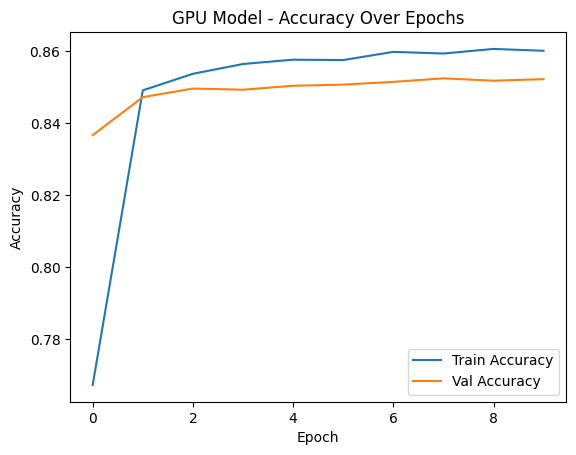

In [11]:
# Accuracy Plot
plt.plot(history_gpu.history['accuracy'], label='Train Accuracy')
plt.plot(history_gpu.history['val_accuracy'], label='Val Accuracy')
plt.title('GPU Model - Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

GPU Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     11232
           1       0.83      0.82      0.83      8497

    accuracy                           0.85     19729
   macro avg       0.85      0.85      0.85     19729
weighted avg       0.85      0.85      0.85     19729



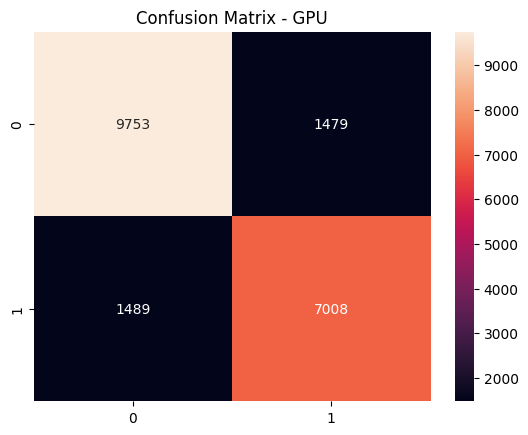

In [13]:
# CONFUSION MATRIX & REPORT

y_pred_gpu = (model_gpu.predict(X_test) > 0.5).astype(int)

print("\nGPU Classification Report:")
print(classification_report(y_test, y_pred_gpu))

sns.heatmap(confusion_matrix(y_test, y_pred_gpu), annot=True, fmt='d')
plt.title("Confusion Matrix - GPU")
plt.savefig("confusion_matrix_gpu.png")
plt.show()

617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


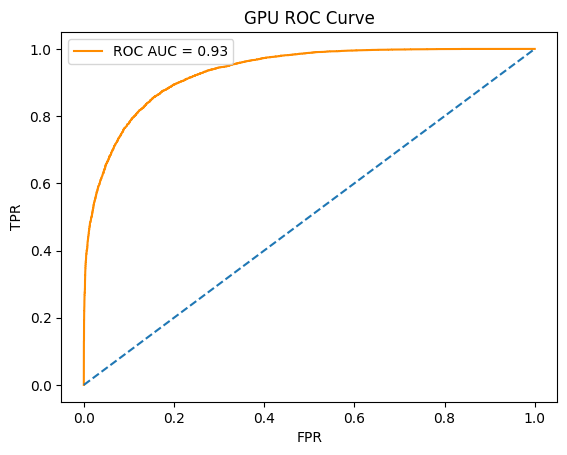

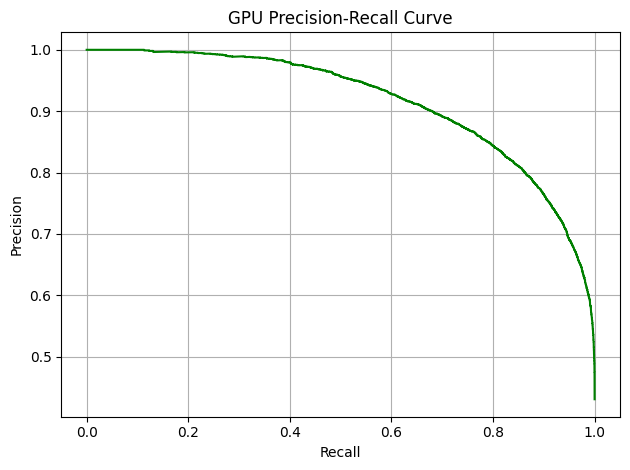

In [14]:
# ROC & PR CURVES - GPU


proba_gpu = model_gpu.predict(X_test).ravel()

fpr, tpr, _ = roc_curve(y_test, proba_gpu)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0,1],[0,1],'--')
plt.title("GPU ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, proba_gpu)
plt.plot(recall, precision, color='green')
plt.title("GPU Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# cuML GPU Logistic Regression


X_cudf = cudf.DataFrame.from_records(X_scaled)
y_cudf = cudf.Series(y.values)

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled, y.values, test_size=0.3, random_state=42, stratify=y.values)

X_train_gpu = cudf.DataFrame.from_records(X_train_np)
X_test_gpu = cudf.DataFrame.from_records(X_test_np)
y_train_gpu = cudf.Series(y_train_np)
y_test_gpu = cudf.Series(y_test_np)

start_gpu = time.time()
cuml_model = cuLogisticRegression()
cuml_model.fit(X_train_gpu, y_train_gpu)
cuml_time = time.time() - start_gpu

preds = cuml_model.predict(X_test_gpu).to_numpy()
acc = accuracy_score(y_test_np, preds)
print(f" cuML GPU Logistic Regression Acc: {acc:.4f} | Time: {cuml_time:.2f} sec")

 cuML GPU Logistic Regression Acc: 0.8494 | Time: 2.42 sec


In [16]:
# Experimental: Batch Size


for batch in [256, 450]:
    print(f"\nBatch Size: {batch}")
    model_exp = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_exp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    with tf.device('/GPU:0'):
        start = time.time()
        model_exp.fit(X_train, y_train, epochs=5, batch_size=batch, verbose=0)
        print(f"Training Time (GPU): {time.time() - start:.2f} sec")

        # Inference latency
        sample = X_test[:1]
        start = time.time()
        _ = model_exp.predict(sample)
        print(f"Inference Latency: {(time.time() - start)*1000:.2f} ms")


Batch Size: 256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time (GPU): 5.95 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Inference Latency: 348.42 ms

Batch Size: 450
Training Time (GPU): 3.75 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Inference Latency: 347.96 ms
